# Regression on EFST with Expn & Mutation

In [1]:
options(warn=-1)
library(kimisc)
library(xlsx)
library(scatterplot3d)
data_full <- read.xlsx("TARGET_AML_ClinicalData_20160714.xlsx",sheetIndex = 1, stringsAsFactors = FALSE)
dimnames(data_full)[[1]] <- data_full[,1]
dim(data_full)
expn <- read.csv("AML_assay_clinical.csv",header=TRUE)
dimnames(expn)[[1]] <- expn[,1]
expn <- expn[, -1]
expn = expn[1:108,]
dim(expn)

[1] 993  63

[1]   108 21491

In [12]:
library(e1071)

In [2]:
binary_s2n<-function(mat,feature){
    efst=mat$Event.Free.Survival.Time.in.Days
    vec=mat[,feature]
    dirty=which((vec=="Unknown")|(vec=="Not done"))
    if (length(dirty)>0){
        vec=vec[-dirty]
        efst=efst[-dirty]}
    vec=as.numeric(as.factor(vec))
    pos=which(vec==1)
    neg=which(vec==2)
    pos_samp=efst[pos]
    neg_samp=efst[neg]
    m1=mean(pos_samp)
    m2=mean(neg_samp)
    sd1=sd(pos_samp)
    sd2=sd(neg_samp)
    return (abs(m1-m2)/(sd2+sd1))
}


In [3]:
binary_features=c('Gender','CNS.disease','Chloroma','t.6.9.','t.8.21.','t.3.5..q25.q34.','t.6.11..q27.q23.','t.9.11..p22.q23.','t.10.11..p11.2.q23.','t.11.19..q23.p13.1.','inv.16.','del5q','del7q','del9q','monosomy.7','trisomy.8','trisomy.21','MLL','Minus.Y','Minus.X')
features2n=lapply(binary_features,function(x){return(binary_s2n(data_full,x))})
binary_features[which(features2n>0.1)]

[1] "Chloroma"            "t.8.21."             "t.3.5..q25.q34."    
 [4] "t.6.11..q27.q23."    "t.9.11..p22.q23."    "t.10.11..p11.2.q23."
 [7] "del5q"               "monosomy.7"          "Minus.Y"            
[10] "Minus.X"

In [4]:
gene_names=colnames(expn[85:21488])
genescor=lapply(gene_names,function(x){return(cor(as.numeric(expn$Event.Free.Survival.Time.in.Days),exp(as.numeric(expn[,x])),use="complete.obs"))})

In [173]:
length(which(abs(as.numeric(genescor))>0.4))
genescor[which.max(abs(as.numeric(genescor)))]
gene_names[which.max(abs(as.numeric(genescor)))]

[1] 57

[[1]]
[1] 0.5141186

[1] "ENSG00000269743.2"

In [281]:
 build_train<-function(expn,genes,binaries){
    genes=as.character(genes)
    mat_1=exp(expn[,genes])
    binaries=as.character(binaries)
    mat_2=expn[,binaries]
    if (mode(mat_2)=='numeric'){
        mat_2=as.character(mat_2)
    }
   
    mat_2[colnames(mat_2)]=lapply(mat_2[colnames(mat_2)] ,as.character)
    mat_2[mat_2=="Unknown" | mat_2=="Not done"]=0
    mat_2[mat_2=="Yes"]=as.numeric(1)
    mat_2[mat_2=="No"]=as.numeric(-1)
    mat_2[colnames(mat_2)]=lapply(mat_2[colnames(mat_2)] ,as.numeric)
    
    mat_1=as.data.frame(mat_1)
    mat_2=as.data.frame(mat_2)
    if (dim(mat_2)[1]!=dim(mat_1)[1]){
        mat_2=t(mat_2)
    }
     
    mat=cbind(mat_1,mat_2)
    mat$Event.Free.Survival.Time.in.Days=expn$Event.Free.Survival.Time.in.Days
    return (mat)
}

In [330]:
train_and_test<-function(expn,genes,binaries,method="lm",size=108){
    mat=build_train(expn,genes,binaries)
    if (size==108){
    test_batches=sample(1:108,12)}
    else{
        test_batches=sample(1:80,8)
    }
    train=mat[-test_batches,]
    test=mat[test_batches,]
    train[is.na(train)] = 0
    test[is.na(test)]=0
    if (method=="lm"){
        res=lm(Event.Free.Survival.Time.in.Days ~ ., data=na.omit(train))
        bck=step(res,trace=0,direction=c("backward"))
        pred=predict(bck,newdata=test)
    }
    if (method=="svr"){
        res=svm(Event.Free.Survival.Time.in.Days ~ ., data=na.omit(train))
        pred=predict(res,test)
    }
    if (method=="svr100"){
        train$Event.Free.Survival.Time.in.Days=round(train$Event.Free.Survival.Time.in.Days/100)
        res=svm(Event.Free.Survival.Time.in.Days ~ ., data=na.omit(train))
        pred=predict(res,test)
        pred=pred*100
    }
    if (method=="segmentsvm"){
        pred=train_pred_svm(train,test,"pred")
    }
    if (method=="segmentglm"){
        pred=train_pred_glm(train,test,"pred")
    }
    resid=pred - test$Event.Free.Survival.Time.in.Days
    RR=norm(resid ,type="2")
    return (RR)
}


[1] 3310.6

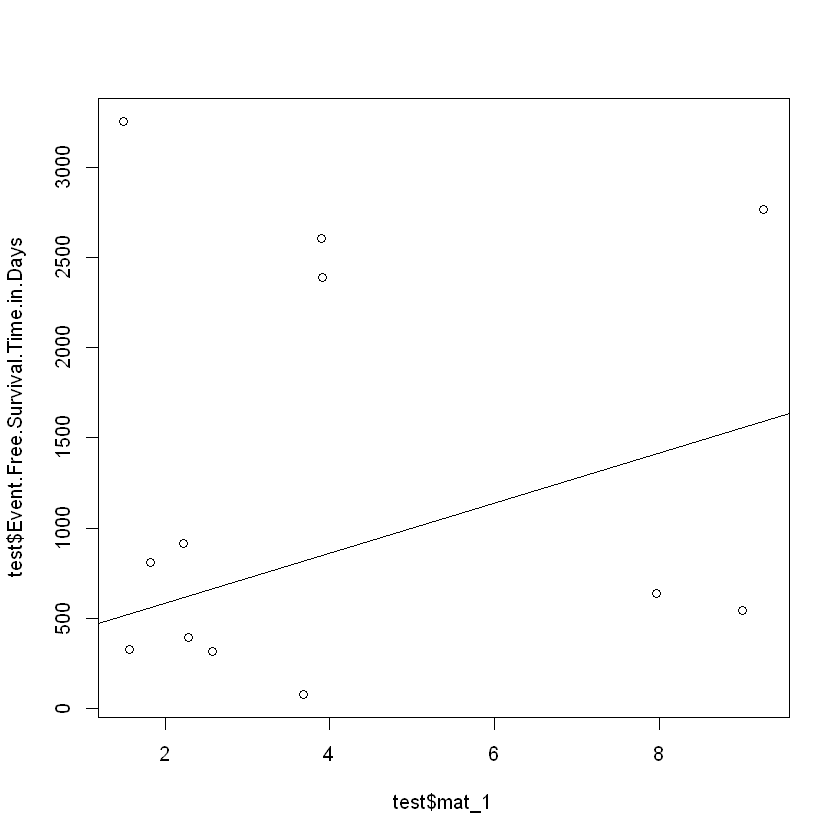

In [8]:
genes=gene_names[which(abs(as.numeric(genescor))>0.5)]
binaries=binary_features[which(features2n>1)]
rr=0
for (i in 1:9){
    rr=rr+train_and_test(expn,genes,binaries,"lm")/9
}
rr
mat=build_train(expn,genes,binaries)
test_batches=sample(1:108,12)
train=mat[-test_batches,]
test=mat[test_batches,]
res=lm(Event.Free.Survival.Time.in.Days ~ mat_1, data=train)
plot(test$mat_1,test$Event.Free.Survival.Time.in.Days)
abline(res)

## Stepwise Linear Regression
57 gene expn correlation > 0.4
10 mutation s2n > 0.2

In [403]:
gene_expns=data.frame(name=gene_names,correlation=abs(as.numeric(genescor)))
ord=order(gene_expns$correlation,decreasing=TRUE)
gene_expns=gene_expns[ord,]
muts=data.frame(name=c(binary_features),s2n=as.numeric(features2n))
ord=order(muts$s2n,decreasing=TRUE)
muts=muts[ord,]
result=data.frame(genes=integer(),mutations=integer(),residual_error=double())
for (g in 1:6){
    for (m in 1:10){
        g10=g*10
        genes=gene_expns$name[1:g10]
        binaries=muts$name[1:m]
    re=0
    for (i in 1:9){
        re=rr+train_and_test(expn,genes,binaries,"lm")/9
    }
    result[nrow(result) + 1,] = list(g*10,m,re)
        
}
}
result

genes,mutations,residual_error
10,1,2879.903
10,2,2810.723
10,3,2797.197
10,4,2860.542
10,5,2961.321
10,6,2959.628
10,7,2861.366
10,8,2647.474
10,9,2849.195
10,10,2960.116


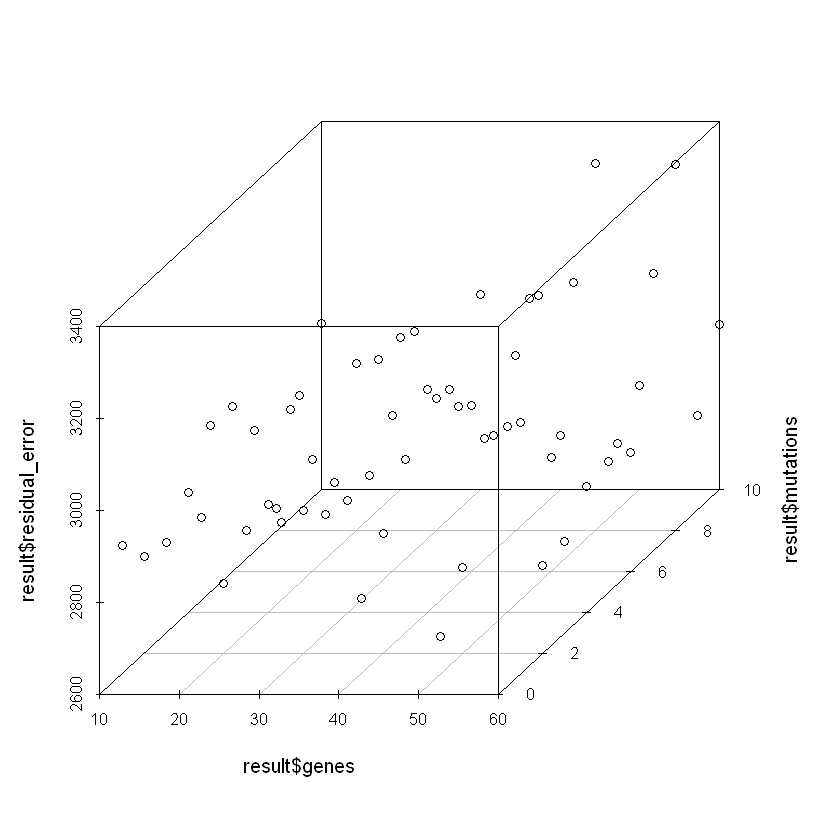

In [404]:
scatterplot3d(result$genes,result$mutations,result$residual_error)
write.csv(result,file="lm.csv")

## SVR (Support Vector Machine Regression)

[1] 3455.293

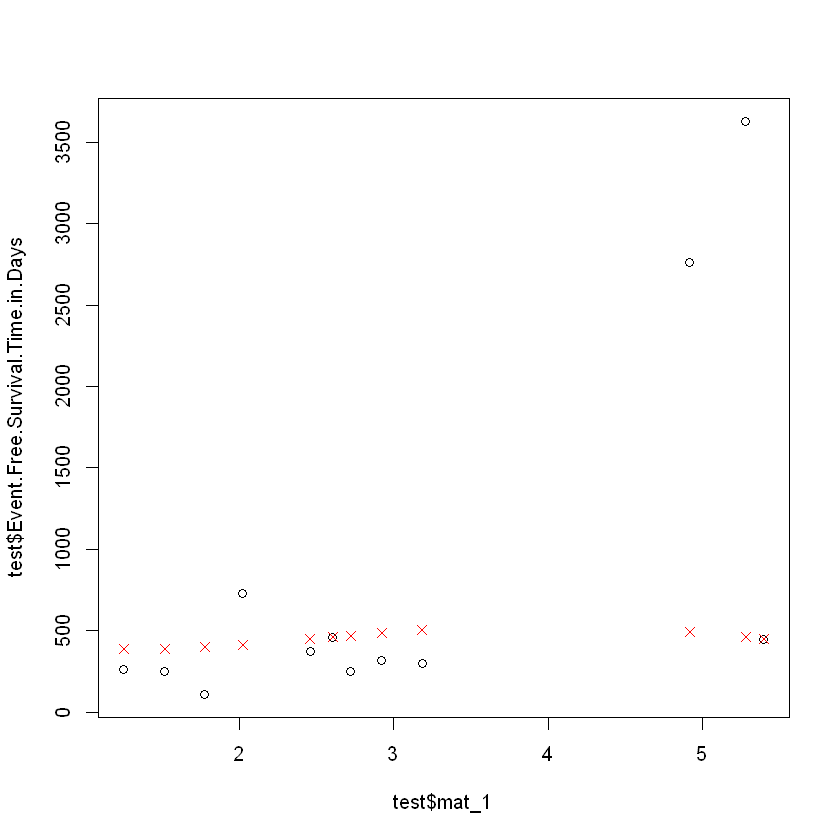

In [33]:
genes=gene_names[which(abs(as.numeric(genescor))>0.5)]
binaries=binary_features[which(features2n>1)]
rr=0
for (i in 1:9){
    rr=rr+train_and_test(expn,genes,binaries,"svr")/9
}
rr
mat=build_train(expn,genes,binaries)
test_batches=sample(1:108,12)
train=mat[-test_batches,]
test=mat[test_batches,]
res=svm(Event.Free.Survival.Time.in.Days ~ mat_1, data=train)
pred=predict(res,test)
plot(test$mat_1,test$Event.Free.Survival.Time.in.Days)
points(test$mat_1, pred, col = "red", pch=4)

In [400]:
gene_expns=data.frame(name=gene_names,correlation=abs(as.numeric(genescor)))
ord=order(gene_expns$correlation,decreasing=TRUE)
gene_expns=gene_expns[ord,]
muts=data.frame(name=c(binary_features),s2n=as.numeric(features2n))
ord=order(muts$s2n,decreasing=TRUE)
muts=muts[ord,]
result=data.frame(genes=integer(),mutations=integer(),residual_error=double())
for (g in 1:6){
    for (m in 1:10){
        g10=g*10
        genes=gene_expns$name[1:g10]
        binaries=muts$name[1:m]
    re=0
    for (i in 1:9){
        re=rr+train_and_test(expn,genes,binaries,"svr")/9
    }
    result[nrow(result) + 1,] = list(g*10,m,re)
        
}
}
result

genes,mutations,residual_error
10,1,2710.853
10,2,2754.344
10,3,2821.428
10,4,2900.697
10,5,2775.736
10,6,2975.934
10,7,2946.134
10,8,2950.506
10,9,3037.000
10,10,2853.808


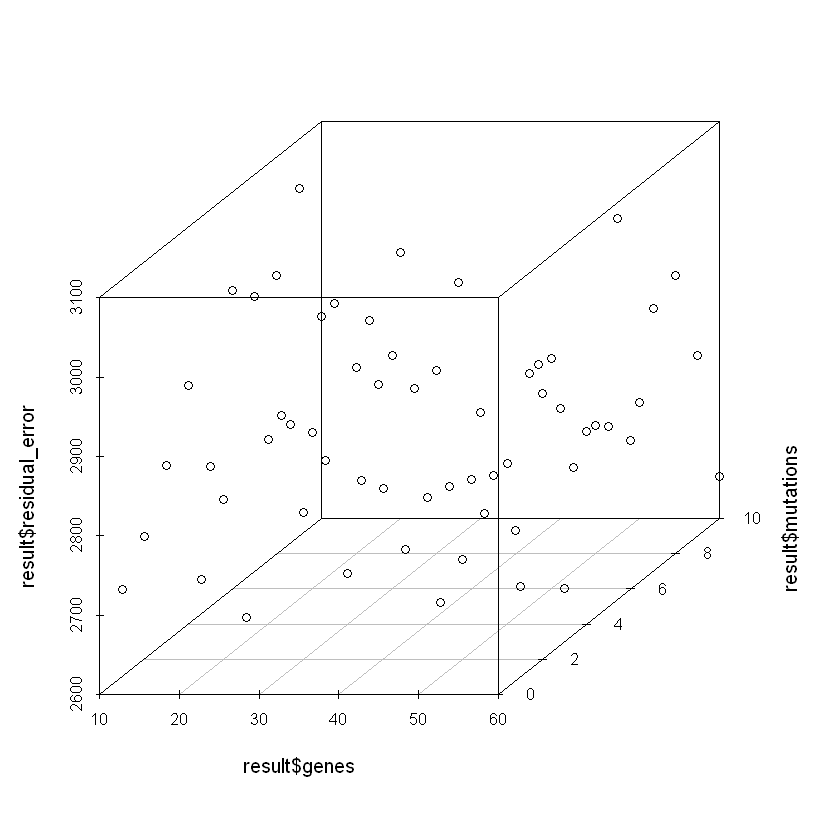

In [402]:
scatterplot3d(result$genes,result$mutations,result$residual_error)
write.csv(result,file="svr.csv")

In [58]:
genes=gene_expns$name[1:20]
binaries=muts$name[1:9]
mat=build_train(expn,genes,binaries)
re=0
for (i in 1:9){
    test_batches=sample(1:108,12)
    train=mat[-test_batches,]
    test=mat[test_batches,]
    train[is.na(train)] = 0
    test[is.na(test)]=0
    res=svm(Event.Free.Survival.Time.in.Days ~ ., data=train)
    tuneResult = tune(svm, Event.Free.Survival.Time.in.Days ~ .,  data = train,
                  ranges = list(epsilon = 0.01, cost = seq(3000,10000,1000))
    )
    pred=predict(tuneResult$best.model,test)
    resid=pred - test$Event.Free.Survival.Time.in.Days
    re=re+norm(resid ,type="2")}
re/9

[1] 3442.01

## 100 Level SVR

[1] 2515.046

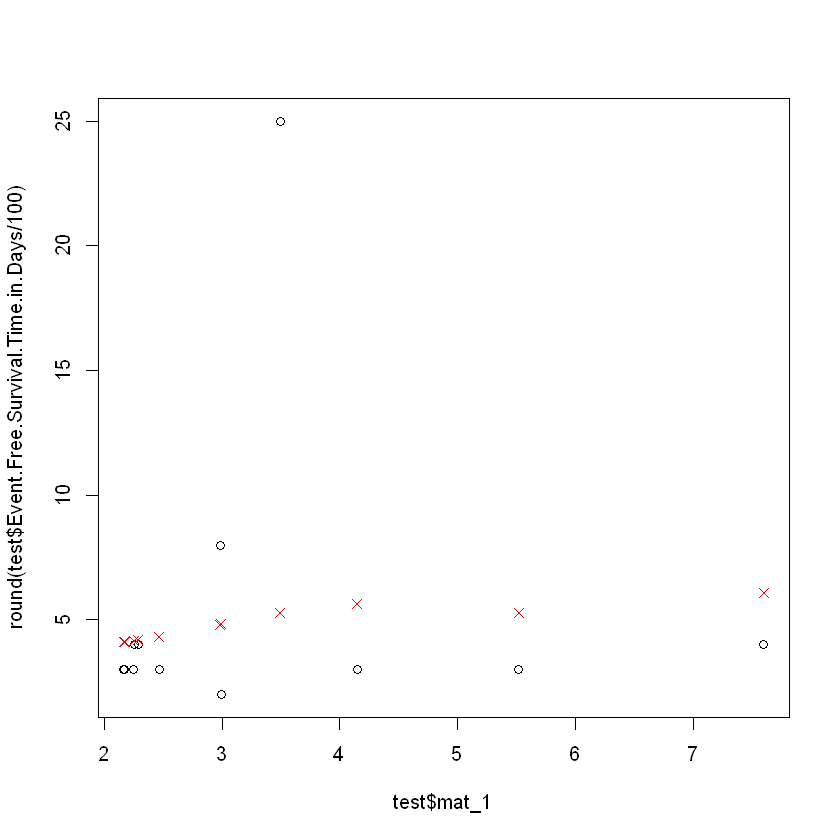

In [80]:
genes=gene_names[which(abs(as.numeric(genescor))>0.5)]
binaries=binary_features[which(features2n>1)]
rr=0
for (i in 1:9){
    rr=rr+train_and_test(expn,genes,binaries,"svr100")/9
}
rr
mat=build_train(expn,genes,binaries)
test_batches=sample(1:108,12)
train=mat[-test_batches,]
test=mat[test_batches,]
train$Event.Free.Survival.Time.in.Days=round(train$Event.Free.Survival.Time.in.Days/100)
res=svm(Event.Free.Survival.Time.in.Days ~ mat_1, data=train)
pred=predict(res,test)
plot(test$mat_1,round(test$Event.Free.Survival.Time.in.Days/100))
points(test$mat_1, pred, col = "red", pch=4)

In [399]:
gene_expns=data.frame(name=gene_names,correlation=abs(as.numeric(genescor)))
ord=order(gene_expns$correlation,decreasing=TRUE)
gene_expns=gene_expns[ord,]
muts=data.frame(name=c(binary_features),s2n=as.numeric(features2n))
ord=order(muts$s2n,decreasing=TRUE)
muts=muts[ord,]
result=data.frame(genes=integer(),mutations=integer(),residual_error=double())
for (g in 1:6){
    for (m in 1:10){
        g10=g*10
        genes=gene_expns$name[1:g10]
        binaries=muts$name[1:m]
    re=0
    for (i in 1:9){
        re=rr+train_and_test(expn,genes,binaries,"svr100")/9
    }
    result[nrow(result) + 1,] = list(g*10,m,re)
        
}
}
result

genes,mutations,residual_error
10,1,2625.295
10,2,2811.762
10,3,2801.506
10,4,2796.166
10,5,2780.861
10,6,2886.615
10,7,2781.171
10,8,2898.524
10,9,2845.890
10,10,2914.471


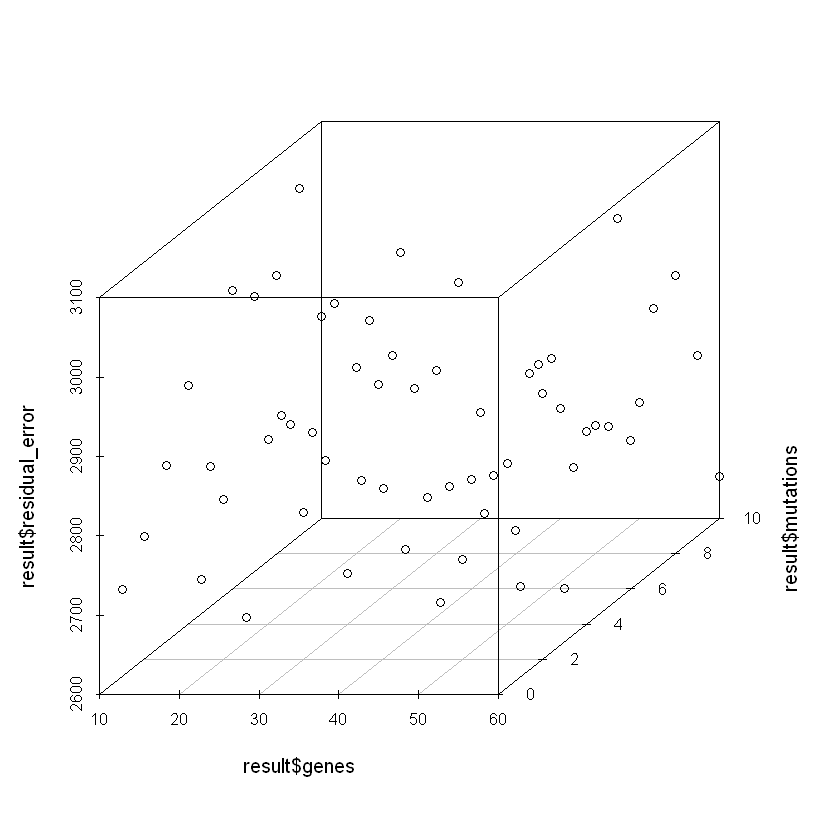

In [401]:
scatterplot3d(result$genes,result$mutations,result$residual_error)
write.csv(result,file="svr100.csv")

## Segment SVM

In [424]:
train_pred_svm<-function(train,test,ret="pred"){
    result=data.frame(idle=rep(0,dim(test)[1]))
    for (i in 1:9){
        #print(test)
        #print(train)
        train_lab=train
        train_lab$Event.Free.Survival.Time.in.Days=as.numeric(train_lab$Event.Free.Survival.Time.in.Days>=i*100)
        if (length(levels(as.factor(train_lab$Event.Free.Survival.Time.in.Days)))==1){
            train_lab[1,"Event.Free.Survival.Time.in.Days"]=1-train_lab[1,"Event.Free.Survival.Time.in.Days"]
        }
        res=svm(Event.Free.Survival.Time.in.Days ~ ., data=na.omit(train_lab))
        pred=round(predict(res,test))
        cn=paste(c("u",toString(i)),collapse="")
        result[,cn]=pred
    }
    clspred=rowSums(result)
    clstest=ceiling(test$Event.Free.Survival.Time.in.Days/100)
    hit=1-sum(abs(clspred-clstest))/length(clspred)/9
    if (ret=="pred"){
        return (clspred*100+50)
    }
    return (hit)
    
}

[1] 0.8611111

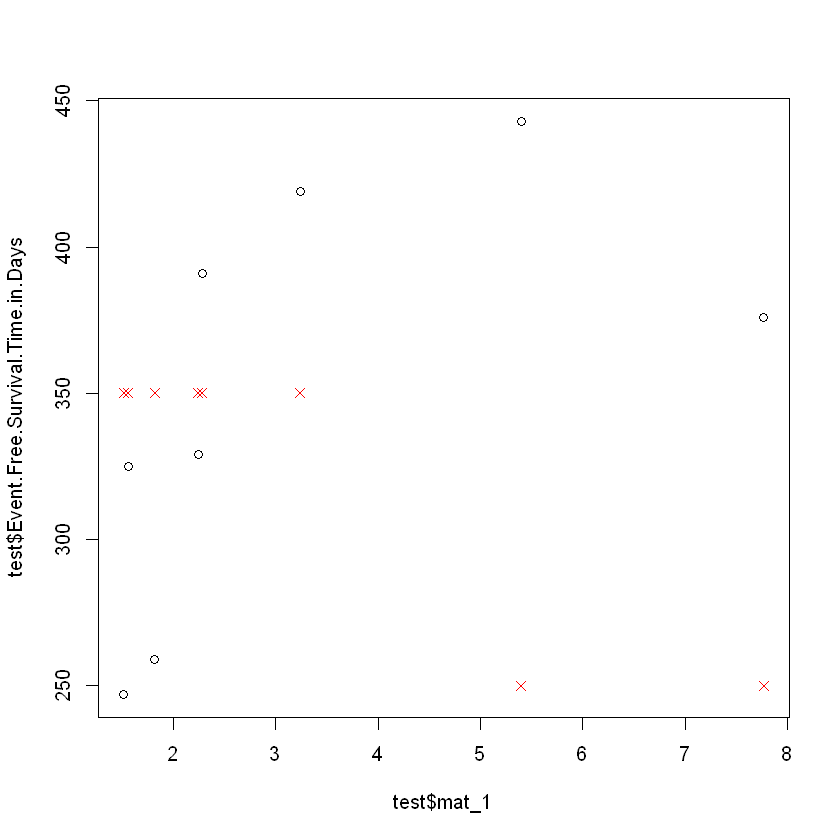

In [425]:
genes=gene_names[which(abs(as.numeric(genescor))>0.5)]
binaries=binary_features[which(features2n>1)]
expn_seg=expn[which(expn$Event.Free.Survival.Time.in.Days<1000),]
mat=build_train(expn_seg,genes,binaries)
test_batches=sample(1:80,8)
train=mat[-test_batches,]
test=mat[test_batches,]
train[is.na(train)] = 0
    test[is.na(test)]=0
train_pred_svm(train,test,"hit")
pred=train_pred_svm(train,test,"pred")
plot(test$mat_1,test$Event.Free.Survival.Time.in.Days)
points(test$mat_1, pred, col = "red", pch=4)

In [426]:
gene_expns=data.frame(name=gene_names,correlation=abs(as.numeric(genescor)))
ord=order(gene_expns$correlation,decreasing=TRUE)
gene_expns=gene_expns[ord,]
muts=data.frame(name=c(binary_features),s2n=as.numeric(features2n))
ord=order(muts$s2n,decreasing=TRUE)
muts=muts[ord,]
result=data.frame(genes=integer(),mutations=integer(),residual_error=double())
for (g in 1:6){
    for (m in 1:10){
        g10=g*10
        genes=gene_expns$name[1:g10]
        binaries=muts$name[1:m]
    re=0
    for (i in 1:9){
        re=rr+train_and_test(expn_seg,genes,binaries,"segmentsvm",80)/9
    }
    result[nrow(result) + 1,] = list(g*10,m,re)
        
}
}
result

genes,mutations,residual_error
10,1,2591.548
10,2,2575.255
10,3,2596.078
10,4,2580.033
10,5,2594.616
10,6,2580.831
10,7,2636.073
10,8,2573.568
10,9,2581.879
10,10,2575.645


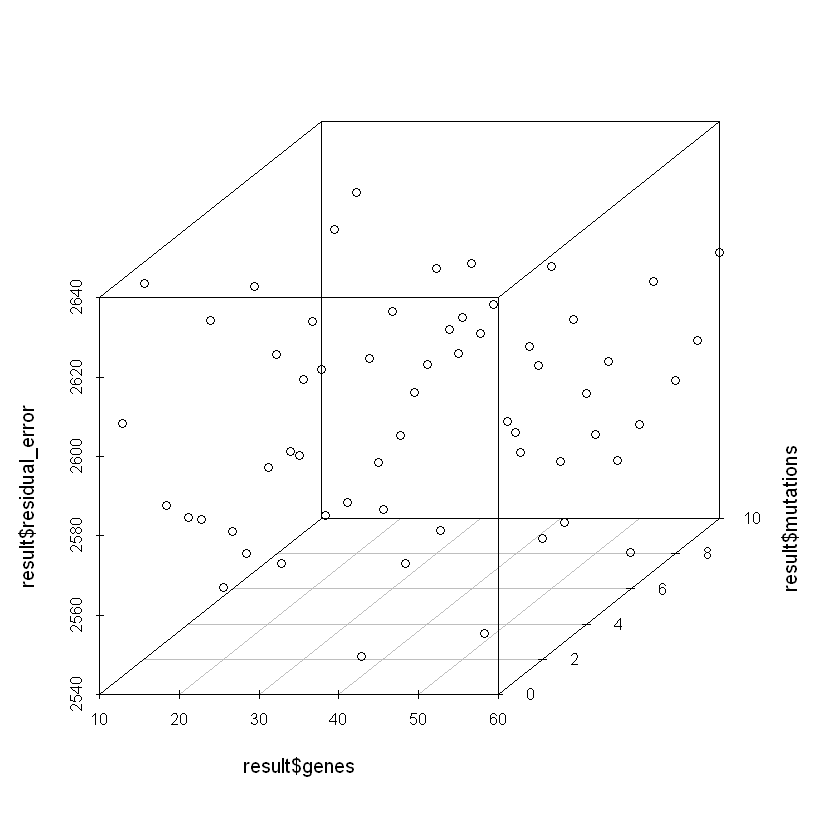

In [398]:
scatterplot3d(result$genes,result$mutations,result$residual_error)
write.csv(result,file="segmentsvm.csv")

## Segment Logistic Regression

In [405]:
train_pred_glm<-function(train,test,ret="pred"){
    result=data.frame(idle=c(0,0,0,0,0,0,0,0))
    for (i in 1:9){
        #print(test)
        #print(train)
        train_lab=train
        train_lab$Event.Free.Survival.Time.in.Days=as.numeric(train_lab$Event.Free.Survival.Time.in.Days>=i*100)
        if (length(levels(as.factor(train_lab$Event.Free.Survival.Time.in.Days)))==1){
            train_lab[1,"Event.Free.Survival.Time.in.Days"]=1-train_lab[1,"Event.Free.Survival.Time.in.Days"]
        }
        res=glm(Event.Free.Survival.Time.in.Days ~ ., data=na.omit(train_lab))
        bck=step(res,trace=0,direction=c("backward"))
        pred=predict(bck,newdata=test)
        pred=round(pred)
        cn=paste(c("u",toString(i)),collapse="")
        result[,cn]=pred
    }
    clspred=rowSums(result)
    clstest=ceiling(test$Event.Free.Survival.Time.in.Days/100)
    hit=1-sum(abs(clspred-clstest))/length(clspred)/9
    if (ret=="pred"){
        return (clspred*100+50)
    }
    return (hit)
    
}

[1] 0.7777778

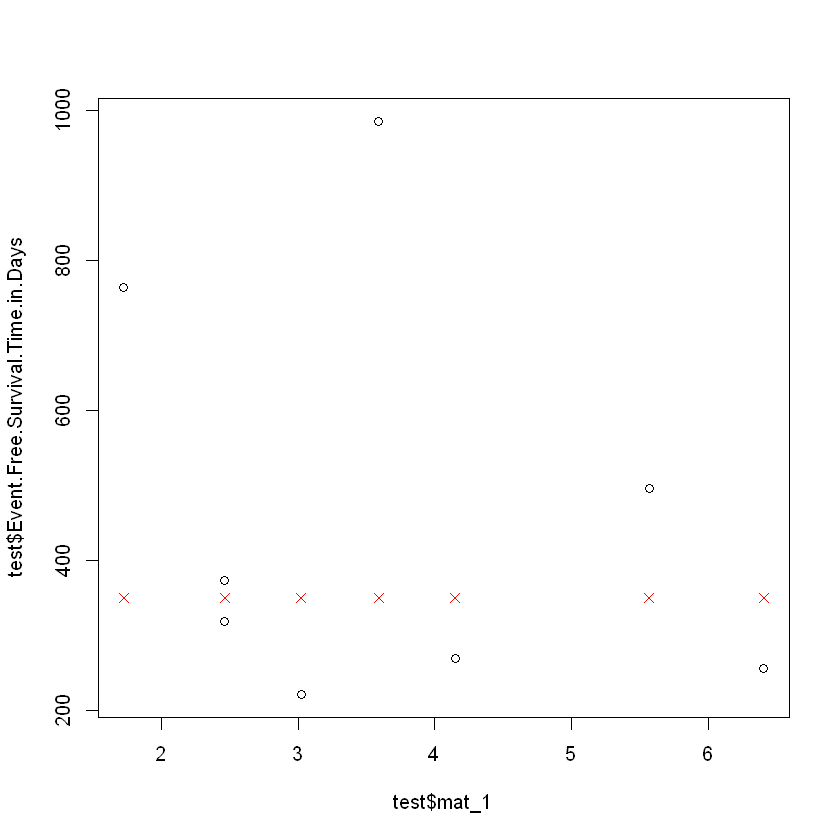

In [406]:
genes=gene_names[which(abs(as.numeric(genescor))>0.5)]
binaries=binary_features[which(features2n>1)]
expn_seg=expn[which(expn$Event.Free.Survival.Time.in.Days<1000),]
mat=build_train(expn_seg,genes,binaries)
test_batches=sample(1:80,8)
train=mat[-test_batches,]
test=mat[test_batches,]
train[is.na(train)] = 0
    test[is.na(test)]=0
train_pred_svm(train,test,"hit")
pred=train_pred_svm(train,test,"pred")
plot(test$mat_1,test$Event.Free.Survival.Time.in.Days)
points(test$mat_1, pred, col = "red", pch=4)

In [407]:
gene_expns=data.frame(name=gene_names,correlation=abs(as.numeric(genescor)))
ord=order(gene_expns$correlation,decreasing=TRUE)
gene_expns=gene_expns[ord,]
muts=data.frame(name=c(binary_features),s2n=as.numeric(features2n))
ord=order(muts$s2n,decreasing=TRUE)
muts=muts[ord,]
result=data.frame(genes=integer(),mutations=integer(),residual_error=double())
for (g in 1:6){
    for (m in 1:10){
        g10=g*10
        genes=gene_expns$name[1:g10]
        binaries=muts$name[1:m]
    re=0
    for (i in 1:9){
        re=rr+train_and_test(expn_seg,genes,binaries,"segmentsvm",80)/9
    }
    result[nrow(result) + 1,] = list(g*10,m,re)
        
}
}
result

genes,mutations,residual_error
10,1,2585.174
10,2,2573.414
10,3,2621.696
10,4,2568.489
10,5,2536.490
10,6,2563.313
10,7,2556.663
10,8,2551.843
10,9,2604.084
10,10,2559.477


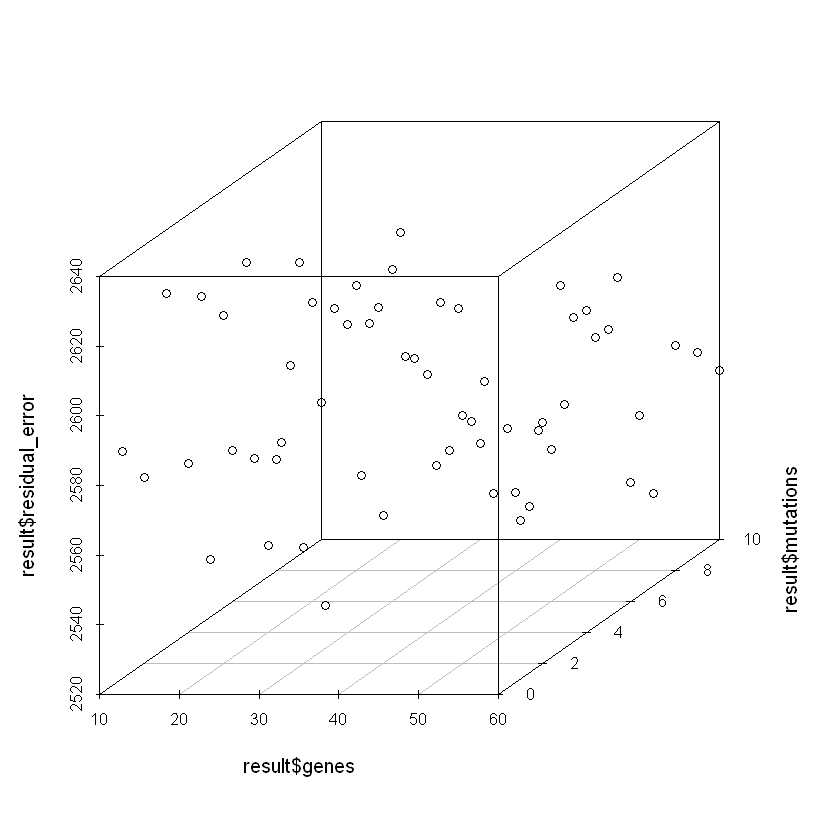

In [408]:
scatterplot3d(result$genes,result$mutations,result$residual_error)
write.csv(result,file="segmentglm.csv")

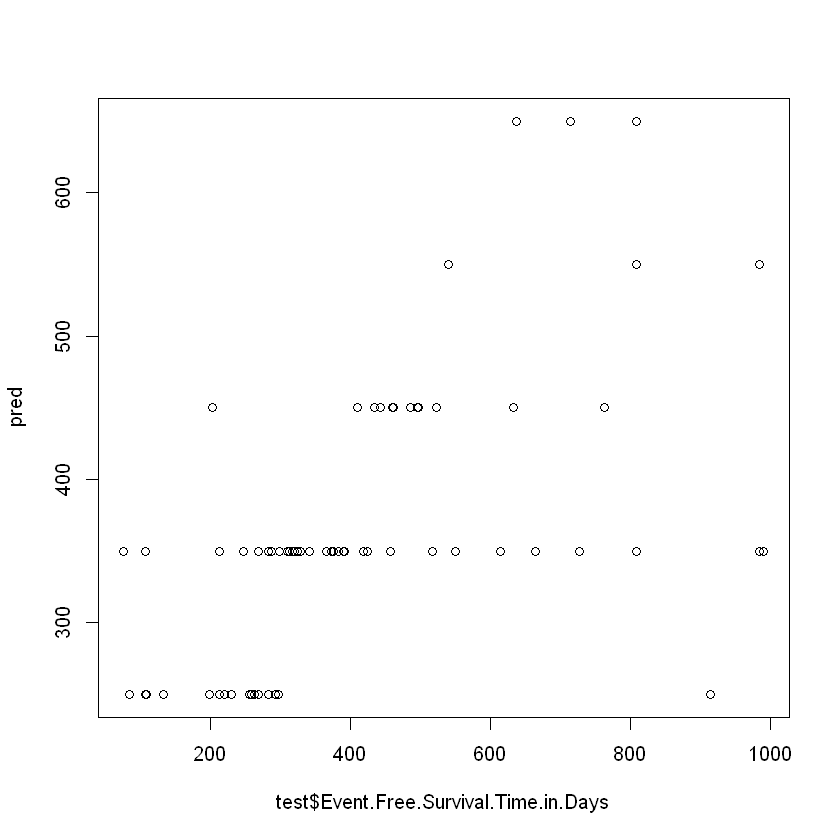

In [442]:
genes=gene_names[which(abs(as.numeric(genescor))>0.4)]
binaries=binary_features[which(features2n>0.2)]
expn_seg=expn[which(expn$Event.Free.Survival.Time.in.Days<1000),]
mat=build_train(expn_seg,genes,binaries)
test_batches=sample(1:80,8)
train=mat[-test_batches,]
test=mat
train[is.na(train)] = 0
    test[is.na(test)]=0
pred=train_pred_svm(train,test,"pred")
plot(test$Event.Free.Survival.Time.in.Days,pred)